In [1]:
from lusidtools.jupyter_tools import toggle_code

"""FX Forward - Valuation Workflow

Attributes
----------
FX Forwards
complex market data
recipes
valuations
"""

toggle_code("Toggle Docstring")

# Booking and valuing an FX Forward

In this notebook, we demonstrate how an FX Forward can be booked in LUSID, and extend it to use cases such as running a standard valuation and calculating PnL.

**Table of Contents:**
- [1. Create Portfolio](#1.-Create-Portfolio)
- [2. Create Instrument](#2.-Create-Instrument)
- [3. Upsert Transactions](#3.-Upsert-Transactions)
- [4. Upsert FX Market Data](#4.-Upsert-FX-Market-Data)
- [5. Create Configuration Recipe](#5.-Create-Configuration-Recipe)
- [6. Valuation](#6.-Valuation)
- [7. Instrument Life Cycle](#7.-Instrument-Life-Cycle)

In [2]:
# Import generic non-LUSID packages
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pytz
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid
import lusid.models as lm
import lusid.api as la
from lusid.utilities import ApiClientFactory
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import key functions from Lusid-Python-Tools and other packages
from lusidjam import RefreshingToken

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.4f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path)

print ('LUSID Environment Initialised')
print ('LUSID API Version :', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID API Version : 0.6.12216.0


In [3]:
# Set required APIs
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
complex_market_data_api = api_factory.build(lusid.api.ComplexMarketDataApi)
aggregation_api = api_factory.build(lusid.api.AggregationApi)

In [4]:
# Define a method to produce numeric axes
def create_curve_axes(spot, rates, tenors, is_pips=False, return_pips=False):

    # Process pips - note that pips are 1 hundredth of a %
    if is_pips:
        rates = [spot + i/10000 for i in rates]

    # Convert tenors
    tenors_in_days = []
    conv_factors = {
        "D": 1,
        "M": 30,
        "W": 7,
        "Y": 365
    }
    for tenor in tenors:
        temp = re.split('(\d+)',tenor)
        tenors_in_days.append(int(temp[1]) * conv_factors[temp[2]])

    # Return either pips or outrights
    if return_pips:
        return tenors_in_days, rates

    else:
        # Initiate x, y arrays for spot
        int_rates = [spot]
        int_tenors = [0]

        # Add numeric tenors and rates
        int_rates.extend(rates)
        int_tenors.extend(tenors_in_days)

        return int_tenors, int_rates

In [5]:
# Define scopes
scope = "ibor"
market_data_scope = "ibor"

# 1. Create Portfolio

We begin by creating a portfolio that will contain the FX forward instrument that we will be looking to price.

In [6]:
portfolio_code = "FxForwardWithPipsCurve"

try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code,
            code=portfolio_code,
            base_currency="EUR",
            created="2010-01-01",
            sub_holding_keys=[],
        ),
    )

except lusid.ApiException as e:
    print(e.body)

{"name":"PortfolioWithIdAlreadyExists","errorDetails":[],"code":112,"type":"https://docs.lusid.com/#section/Error-Codes/112","title":"Could not create a portfolio with id 'FxForwardWithPipsCurve' because it already exists in scope 'ibor'.","status":400,"detail":"Error creating portfolio with id 'FxForwardWithPipsCurve' in scope 'ibor' effective at 2010-01-01T00:00:00.0000000+00:00 because it already exists.","instance":"https://demo.lusid.com/app/insights/logs/0HMV5U2GI5DPQ:0000014C","extensions":{}}


# 2. Create Instrument

Using the below method we can reference the SDK models to populate the required parameters for creating an FX forward. We then populate the instrument variables, and make a call to persist the instrument in LUSID.

In [7]:
# Define function that creates an FX forward

def create_fx_forward(
        dom_amount,
        fgn_amount,
        dom_ccy,
        fgn_ccy,
        start_date,
        maturity_date
):
    return lm.FxForward(
        dom_amount=dom_amount,
        fgn_amount=fgn_amount,
        dom_ccy=dom_ccy,
        fgn_ccy=fgn_ccy,
        start_date=start_date,
        maturity_date=maturity_date,
        instrument_type="FxForward",
    )

# Define a function to upsert instrument
def upsert_instrument_to_lusid(instrument_definition, name, identifier, identifier_type):
        return instruments_api.upsert_instruments(
            request_body={
                identifier: lm.InstrumentDefinition(
                    name=name,
                    identifiers={
                        identifier_type: lm.InstrumentIdValue(value=identifier)
                    },
                    definition=instrument_definition,
                )
            }
        )

For this example we will be creating a 6M EUR/USD forward, with the following characteristics:
- Forward Exchange Rate (Strike): 1.21552025
- Buy/Receive: EUR
- Sell/Pay: USD
- Start Date: 20 Jan 2021
- Maturity Date: 20 July 2021

In [8]:
# Set the instrument variables
forward_name = "EUR/USD 6M FX Forward 20210720"
forward_identifier = "FWD-EURUSD20210720"
identifier_type = "ClientInternal"
description = "EUR/USD FX Forward 20210720"
start_date = datetime(2021, 1, 20, tzinfo=pytz.utc)
maturity_date = datetime(2021, 7, 20, tzinfo=pytz.utc)
dom_ccy = "EUR"
fgn_ccy = "USD"
dom_amount = 1000000
fgn_amount = -1215520.25

In [9]:
# Create the Instrument
forward_definition = create_fx_forward(
    dom_amount=dom_amount,
    fgn_amount=fgn_amount,
    dom_ccy=dom_ccy,
    fgn_ccy=fgn_ccy,
    start_date=start_date,
    maturity_date=maturity_date
)

# Upsert the instrument
upsert_response = upsert_instrument_to_lusid(forward_definition, forward_name, forward_identifier, identifier_type)
luid = upsert_response.values[forward_identifier].lusid_instrument_id
print(luid)

LUID_0000QFB7


# 3. Upsert Transactions

Having created the portfolio, we add a _StockIn_ transaction against the forward to create a position without incurring any costs. Notice that this transaction type will simply increase our position by the given units, as opposed to a typical _Buy_/_Sell_, that would also impact cash.

In [10]:
# Set trade variables
trade_date = datetime(2021, 1, 20, tzinfo=pytz.utc)
settle_days = 2
units = 1

# Book a StockIn transaction against the forward
fwd_txn = lm.TransactionRequest(
    transaction_id="TXN001",
    type="StockIn",
    instrument_identifiers={"Instrument/default/ClientInternal": forward_identifier},
    transaction_date=trade_date.isoformat(),
    settlement_date=(trade_date + timedelta(days=settle_days)).isoformat(),
    units=units,
    transaction_price=lm.TransactionPrice(price=1,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=1,currency="USD"),
    exchange_rate=1,
    transaction_currency="USD"
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[fwd_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

Transaction successfully updated at time: 2023-11-16 01:24:37.589138+00:00


# 4. Upsert FX Market Data

Next we will be loading the required marked data into the quotes store. In this particular example, we will be using both spot rates as well as an FX forward curve, where the latter will need to be loaded using LUSID's complex market data APIs.

# 4.1 FX Spot Rates

We begin by adding the FX spot rates, which are the first piece of market data required to value an FX forward on a given day.

In [11]:
# Read fx spot rates and make datetimes timezone aware
quotes_df = pd.read_csv("data/eurusd_spot.csv")
quotes_df["Date"] = pd.to_datetime(quotes_df["Date"], dayfirst=True)
quotes_df["Date"] = quotes_df["Date"].apply(lambda x: x.replace(tzinfo=pytz.utc))
quotes_df.head()

,Date,Rate,Pair
0,2021-01-01 00:00:00+00:00,1.2215,EUR/USD
1,2021-01-04 00:00:00+00:00,1.2248,EUR/USD
2,2021-01-05 00:00:00+00:00,1.2298,EUR/USD
3,2021-01-06 00:00:00+00:00,1.2327,EUR/USD
4,2021-01-07 00:00:00+00:00,1.2272,EUR/USD


In [12]:
# Create quotes request
instrument_quotes = {
            index: lm.UpsertQuoteRequest(
            quote_id=lm.QuoteId(
                quote_series_id=lm.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=row["Pair"],
                    instrument_id_type="CurrencyPair",
                    quote_type="Rate",
                    field="mid",
                ),
                effective_at=row["Date"].isoformat(),
            ),
            metric_value=lm.MetricValue(value=row["Rate"], unit=row["Pair"]),
        )
    for index, row in quotes_df.iterrows()
}

# Upsert quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=market_data_scope, request_body=instrument_quotes
)

if response.failed == {}:
    print(f"Quotes successfully loaded into LUSID. {len(response.values)} quotes loaded.")
else:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

Quotes successfully loaded into LUSID. 223 quotes loaded.


# 4.2 FX Forward Curve

Next we will read in our FX forward curve data, and create a `ComplexMarketData` object that can be loaded into LUSID's market data store to be used for valuation. Notice, in this example our curve is composed of points rather than outrights, which are commonly referred to as pips as well. These will be added to the spot rate of the day a valuation is run, and need to be scaled so that they are in the correct order of magnitude.

In [13]:
# Read FX forward curve data - showing first 10 terms
fwd_df = pd.read_csv("data/fwd_curve.csv")
fwd_df.head(10)

,Tenor,Points Mid
0,1D,0.6375
1,1W,1.4975
2,2W,3.0275
3,3W,4.5625
4,1M,6.7525
5,2M,19.5125
6,3M,27.3225
7,4M,34.0625
8,5M,41.5175
9,6M,49.2025


In [14]:
# Set the curve variables
market_data_type = "FxForwardTenorPipsCurveData"

forward_curve_data = lm.FxForwardTenorPipsCurveData(
    base_date=trade_date,
    dom_ccy="EUR",
    fgn_ccy="USD",
    tenors=[row["Tenor"] for i, row in fwd_df.iterrows()],
    pip_rates=[row["Points Mid"] for i, row in fwd_df.iterrows()],
    market_data_type=market_data_type
)

forward_curve_id = lm.ComplexMarketDataId(
    provider="Lusid",
    lineage="FxForwardCurveTenorPipsDemo",
    price_source=None,
    effective_at=trade_date,
    market_asset="EUR/USD/FxFwdCurve"
)

complex_market_data_request = lm.UpsertComplexMarketDataRequest(
    market_data_id=forward_curve_id,
    market_data=forward_curve_data
)

# Upsert forward curve into LUSID
response = complex_market_data_api.upsert_complex_market_data(
    scope=market_data_scope,
    request_body={"1": complex_market_data_request}
)

if response.failed == {}:
    print(f"Curves successfully loaded into LUSID. {len(response.values)} curves loaded.")
else:
    print(f"Some failures occurred during quotes upsertion, {len(response.failed)} did not get loaded into LUSID.")

Curves successfully loaded into LUSID. 1 curves loaded.


We can also use the _ComplexMarketDataApi_ to retrieve the data as it's been stored in LUSID. See below for the returned object, and a plot showing a dissection of the pips curve. Within LUSID, these pips will be overlaid on the effective spot rate in order to compute the forward rate.

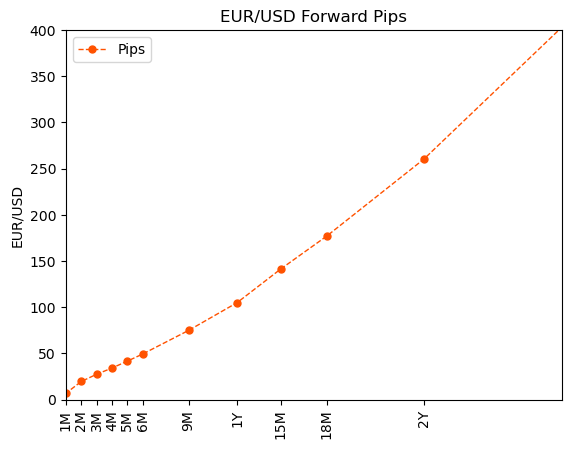

In [15]:
# Retrieve curve
forward_curve = complex_market_data_api.get_complex_market_data(
    scope=market_data_scope,
    effective_at = forward_curve_id.effective_at.isoformat(),
    request_body= {"1": forward_curve_id}
)

# Get axis data and create plot
x, y = create_curve_axes(0, forward_curve.values["1"].pip_rates, forward_curve.values["1"].tenors, False, True)
plt.plot(x,y, color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Pips")
x_tenors = forward_curve.values["1"].tenors
plt.xticks(x, x_tenors, rotation='vertical')
plt.title('EUR/USD Forward Pips')
plt.ylabel('EUR/USD')
plt.xlim([30, 1000]), plt.ylim([0, 400])
plt.legend(loc="upper left")
plt.show()

# 5. Create Configuration Recipe

In order to run a valuation, LUSID will require a recipe that drives how a valuation will be conducted. The below recipe defines what model and market data to use in this context.

Within the market context we provide 2 rules, where the first defines a ruleset for spot rates and the other references our FX forward curve. Notice also that we have applied a long quote interval (1Y) for the forward curve, which defines the look-back period for reusing the data set on multiple valuation dates.

For the valuation model we have selected `ForwardFromCurveUndiscounted`, which allows for the valuation of an FX forward using an FX forward curve. In our case it will also create the forward curve from the previously seen pips along with the daily spot. This model will calculate the forward's value on the fly by interpolating the matching point on the curve for the instrument's maturity, using the following formula.

```
PV = (S - K) / S * notionalBase

Where;

S = Interpolated Forward Rate

K = Strike

```

As the name implies, this model doesn't apply any discounting in computing the instrument's market value. In LUSID this is supported using the model `ForwardFromCurve`, which would require the addition of a discount curve into the complex market data store.

In [16]:
# Define a method for creating the recipe
def create_recipe(recipe_code, separate_otc_legs=False):

    # Populate recipe parameters
    return lm.ConfigurationRecipe(
        scope=scope,
        code=recipe_code,
        market=lm.MarketContext(
            market_rules=[
                lm.MarketDataKeyRule(
                    key="FX.CurrencyPair.*",
                    supplier="Lusid",
                    data_scope=market_data_scope,
                    quote_type="Rate",
                    field="mid",
                    quote_interval="5D.0D"
                ),
                lm.MarketDataKeyRule(
                    key="FxForwards.*.*.*",
                    supplier="Lusid",
                    data_scope=market_data_scope,
                    quote_type="Rate",
                    field="mid",
                    quote_interval="1Y.0D"
                )
            ],
            options=lm.MarketOptions(
                attempt_to_infer_missing_fx=True,
                default_scope=market_data_scope
            )
        ),
        # Set the valuation model - curve with no discounting
        pricing=lm.PricingContext(
            model_rules=[
                lm.VendorModelRule(
                    supplier="Lusid",
                    model_name="ForwardFromCurveUndiscounted",
                    instrument_type="FxForward",
                    parameters="{}",
                    # Optional - will make FX conversion done using forward rate not spot
                    model_options=lm.FxForwardModelOptions(
                            forward_rate_observable_type="Invalid",
                            discounting_method="Invalid",
                            convert_to_report_ccy=False,
                            model_options_type="FxForwardModelOptions"
                        )
                ),
            ],
            options=lm.PricingOptions(
                produce_separate_result_for_linear_otc_legs=separate_otc_legs
            )
        ),
    )

By default, LUSID will price an _FxForward_ instrument as a single line-item, which yields the net market value. However, in some use cases it may be needed to produce the leg level market value, which can be managed in the recipe's pricing options.

In this example we create 2 recipes, one that produces the net market value and another that splits the instrument to its leg components. This is driven by the `produce_separate_result_for_linear_otc_legs` parameter in the configuration recipe.

In [17]:
# Create recipes for net and leg level valuation
net_recipe_code = "FxForwardValuation"
sep_recipe_code = "FxForwardValuationSeparated"

standard_recipe = create_recipe(net_recipe_code, False)
separate_legs_recipe = create_recipe(sep_recipe_code, True)

for recipe in [standard_recipe, separate_legs_recipe]:
    response = configuration_recipe_api.upsert_configuration_recipe(
            upsert_recipe_request=lm.UpsertRecipeRequest(
                configuration_recipe=recipe
            )
        )

    print(f"Configuration recipe loaded into LUSID at time {response.value}.")

Configuration recipe loaded into LUSID at time 2023-11-16 01:39:29.848323+00:00.
Configuration recipe loaded into LUSID at time 2023-11-16 01:39:29.990097+00:00.


# 6. Valuation

In order to value the portfolio, we will need to create a valuation request that specifies the metrics that are to be returned, and reference our previously setup portfolio and recipe on a given date. The following method will return the results in form of a data frame.

In [18]:
# Set the queryable metrics and operation to be applied on the group_by level
metrics = [
    lm.AggregateSpec("Instrument/default/Name", "Value"),
    lm.AggregateSpec("Instrument/default/ClientInternal", "Value"),
    lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
    lm.AggregateSpec("Valuation/Diagnostics/FxForwardRate", "Value"),
    lm.AggregateSpec("Quotes/FxRate/DomFgn", "Value"),
    lm.AggregateSpec("Holding/default/Units", "Value"),
    lm.AggregateSpec("Valuation/PnL/Tm1/Pfolio", "Value"),
        ]

# Method to query daily valuations
def get_daily_valuation(date, portfolio_code, recipe_code, metrics, group_by=["Instrument/default/Name"]):

    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=scope, code=recipe_code),
        metrics=metrics,
        group_by=group_by,
        portfolio_entity_ids=[
            lm.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=lm.ValuationSchedule(effective_at=date.isoformat()),
    )

    val_data = aggregation_api.get_valuation(valuation_request=valuation_request).data

    vals_df = pd.DataFrame(val_data)

    vals_df.rename(
        columns={
            "Instrument/default/Name": "InstrumentName",
            "Instrument/default/ClientInternal": "ClientInternal",
            "Valuation/PvInPortfolioCcy": "Market Value (Portfolio Currency)",
            "Valuation/Diagnostics/FxForwardRate": "Forward Rate (Interpolated)",
            "Quotes/FxRate/DomFgn": "FX Spot Rate",
            "Valuation/PnL/Tm1/Pfolio": "PnL (1-day)",
            "Valuation/PV/Ccy": "Leg Currency"
        },
        inplace=True,
    )

    return vals_df

# 6.1 Daily Valuation and PnL

# Day 1

We begin by valuing the position as of the trade date, where based on the available forward curve and spot rates, we can observe the following market values for the positions within the portfolio.

In [19]:
df = get_daily_valuation(trade_date, portfolio_code, net_recipe_code, metrics)
df.drop('Aggregation/Errors', axis=1, inplace=True)
df

,InstrumentName,ClientInternal,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate,Holding/default/Units,PnL (1-day)
0,EUR/USD 6M FX Forward 20210720,FWD-EURUSD20210720,-42.1511,1.2155,1.2106,1.0000,None


As we can see, the current market value for the forward is zero. This is because our current implied forward rate is equal to the strike on our forward instrument. We can illustrate this on the curve, as seen below, with our instrument's forward rate highlighted in blue.

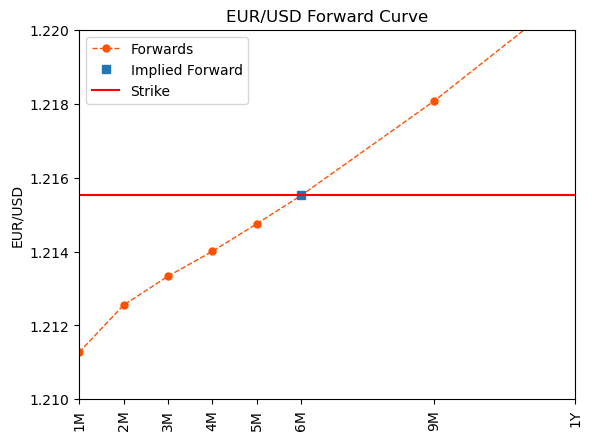

In [20]:
# Get axis data and create plot
x, y = create_curve_axes(1.2106, forward_curve.values["1"].pip_rates, forward_curve.values["1"].tenors, True)
plt.plot(x,y, color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Forwards")
plt.plot(180, 1.21552025,'s', label="Implied Forward")
plt.axhline(y=1.21552025, color='r', label="Strike")
x_tenors = ["0D"] + forward_curve.values["1"].tenors
plt.xticks(x, x_tenors, rotation='vertical')
plt.title('EUR/USD Forward Curve')
plt.ylabel('EUR/USD')
plt.xlim([30, 365]), plt.ylim([1.21, 1.220])
plt.legend(loc="upper left")
plt.show()

# Day 2

On the following date, we observe a new market value and also observe a daily PnL as a result of a price change against the previous day's market value.

Notice that in this case we are re-using the curve upserted on the trade date, however, the market values are moving along with a change in the spot rate. Given we have a curve composed of points, rather than outrights, the fx forward curve will shift along with the spot rate. (In a real world implementation, it would be more accurate to update the curve daily.)

In [21]:
df = get_daily_valuation(trade_date + timedelta(days=1), portfolio_code, net_recipe_code, metrics)
df

,InstrumentName,ClientInternal,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate,Holding/default/Units,PnL (1-day)
0,EUR/USD 6M FX Forward 20210720,FWD-EURUSD20210720,"4,707.2075",1.2213,1.2164,1.0000,"4,749.3586"


As we can see, we have a positive market value which stems from the fact that the interpolated forward has moved above our strike, which means entering a similar contract today would be more expensive.

Moreover, the PV in USD base terms is arrived to as follows:

```
PVlocal = (1.22132025 - 1.21552025) /1.22132025 * 1,000,000.00
PVlocal = EUR 4748.9592

```

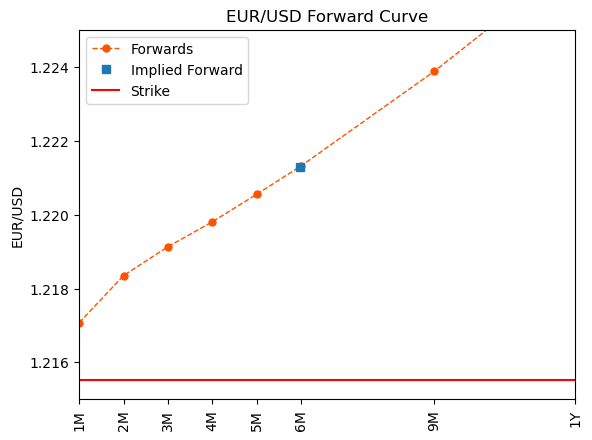

In [22]:
# Get axis data and create plot
x, y = create_curve_axes(1.2164, forward_curve.values["1"].pip_rates, forward_curve.values["1"].tenors, True)
plt.plot(x,y, color='#ff5200' , marker='o', markersize=5, linestyle='--', linewidth=1, label="Forwards")
plt.plot(179, 1.2213,'s',label="Implied Forward")
x_tenors = ["0D"] + forward_curve.values["1"].tenors
plt.xticks(x, x_tenors, rotation='vertical')
plt.axhline(y=1.21552025, color='r', label="Strike")
plt.title('EUR/USD Forward Curve')
plt.ylabel('EUR/USD')
plt.xlim([30, 365]), plt.ylim([1.215, 1.225])
plt.legend(loc="upper left")
plt.show()

# Day 3

On day 3, we again run the same query and observe a daily gain, as well as the latest market value and price.

In [23]:
df = get_daily_valuation(trade_date + timedelta(days=2), portfolio_code, net_recipe_code, metrics)
df

,InstrumentName,ClientInternal,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate,Holding/default/Units,PnL (1-day)
0,EUR/USD 6M FX Forward 20210720,FWD-EURUSD20210720,"5,277.3569",1.2220,1.2171,1.0000,570.1494


We notice a daily PnL in the portfolio base currency, which is a result of:

```
PnL = (PV1local - PV0local)

PnL = (5319.0608 - 4748.9592) = 570.1016
```

# 6.2 Leg level valuation

LUSID can also value OTC instruments that are composed of multiple legs at the individual leg level. We can see this here for Day 3, where we replace the recipe with the one that splits the instrument as shown below.

In [24]:
# Run with separate legs

new_metrics = [
    lm.AggregateSpec("Instrument/default/Name", "Value"),
    lm.AggregateSpec("Valuation/PV/Ccy", "Value"),
    lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"),
    lm.AggregateSpec("Valuation/Diagnostics/FxForwardRate", "Value"),
    lm.AggregateSpec("Quotes/FxRate/DomFgn", "Value"),
        ]

df = get_daily_valuation(trade_date + timedelta(days=3), portfolio_code, sep_recipe_code, new_metrics, ["Instrument/default/Name",  "Valuation/PvInPortfolioCcy"])
df

,Leg Currency,InstrumentName,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate
0,EUR,EUR/USD 6M FX Forward 20210720,"1,000,000.0000",1.2220,None
1,USD,EUR/USD 6M FX Forward 20210720,"-994,722.6431",1.2220,None


# 7. Instrument Life Cycle

# 7.1 Rolling over the contract

As seen previously, the instrument we've held has a positive market value, which means we could unwind the position and realize a gain on any of day 2 or 3. If a hedge is still needed in place, this could be done by rolling over to a new forward.

Rolling the forward contract can also be used dynamically to ensure periodic cash flows in foreign currencies remain hedged. Below we show an example of unwinding an existing forward, realising the gain/loss and entering a new contract. This is done using our previous example with 1M into the contracts life cycle.

In [25]:
# Query valuations as of day 30
df = get_daily_valuation(trade_date + timedelta(days=30), portfolio_code, net_recipe_code, metrics)
df

,InstrumentName,ClientInternal,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate,Holding/default/Units,PnL (1-day)
0,EUR/USD 6M FX Forward 20210720,FWD-EURUSD20210720,"1,026.2972",1.2168,1.2119,1.0000,"2,221.6439"


In order to realize the gain/loss, we use the market value of the forward as the cost of the transaction unwinding our position.

In [26]:
# Store market value - to be realized as cash settlement
market_val = df["Market Value (Portfolio Currency)"][0]

# Set trade parameters
unwind_date = trade_date + timedelta(days=30, hours=12)

# Book a sell transaction against the forward
fwd_txn = lm.TransactionRequest(
    transaction_id="TXN002",
    type="Sell",
    instrument_identifiers={"Instrument/default/ClientInternal": forward_identifier},
    transaction_date=unwind_date.isoformat(),
    settlement_date=(unwind_date + timedelta(days=settle_days)).isoformat(),
    units=units,
    transaction_price=lm.TransactionPrice(price=1,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=market_val,currency="USD"),
    exchange_rate=1,
    transaction_currency="USD"
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[fwd_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

Transaction successfully updated at time: 2023-11-16 01:24:37.589138+00:00


Having unwound our position with our realized gain as cash, we can now enter a new forward with our counterparty, rolling the hedge forward. To this end we will create and book the following instrument:

- Forward Exchange Rate (Strike): 1.2168
- Buy/Receive: EUR
- Sell/Pay: USD
- Start Date: 19 Feb 2021
- Maturity Date: 19 Aug 2021

In [27]:
# Set the instrument variables
forward_name2 = "EUR/USD 6M FX Forward 20210819"
forward_identifier2 = "FWD-EURUSD20210819"
identifier_type = "ClientInternal"
description = "EUR/USD FX Forward 20210819"
start_date = datetime(2021, 2, 19, tzinfo=pytz.utc)
maturity_date = datetime(2021, 8, 19, tzinfo=pytz.utc)
dom_ccy = "EUR"
fgn_ccy = "USD"
dom_amount = 1000000
fgn_amount = -1216800

# Create the forward
forward_definition = create_fx_forward(
    dom_amount=dom_amount,
    fgn_amount=fgn_amount,
    dom_ccy=dom_ccy,
    fgn_ccy=fgn_ccy,
    start_date=start_date,
    maturity_date=maturity_date
)

# Upsert the instrument
upsert_response = upsert_instrument_to_lusid(forward_definition, forward_name2, forward_identifier2, identifier_type)
luid = upsert_response.values[forward_identifier2].lusid_instrument_id
print(luid)

LUID_0000QFB8


We then enter the forward position with a _StockIn_, similar to what was done with our previous instrument.

In [28]:
# Book a StockIn transaction against the new forward
fwd_txn = lm.TransactionRequest(
    transaction_id="TXN003",
    type="StockIn",
    instrument_identifiers={"Instrument/default/ClientInternal": forward_identifier2},
    transaction_date=unwind_date.isoformat(),
    settlement_date=(unwind_date + timedelta(days=settle_days)).isoformat(),
    units=units,
    transaction_price=lm.TransactionPrice(price=1,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=1,currency="USD"),
    exchange_rate=1,
    transaction_currency="USD"
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[fwd_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")


Transaction successfully updated at time: 2023-11-16 01:39:35.537910+00:00


# 7.2 Upsertable Cash Flows

For the instrument's life cycle events, LUSID has a native cash flows API end point that allows a user to query upcoming portfolio flows. The example below shows an example that retrieves the cash flows occurring at maturity for the FX forward, as shown below for both the EUR and USD legs.

Notice that the results of the _UpsertableCashFlows_ call will be composed of headers that match an _UpsertTransactions_ payload, which means it can be used to execute life cycle events as part of a scripted process.

In [29]:
upsertable_cash_flows = transaction_portfolios_api.get_upsertable_portfolio_cash_flows(
    scope=scope,
    code=portfolio_code,
    effective_at="2021-02-21T12:00:00Z",
    window_start=trade_date,
    window_end=maturity_date,
    recipe_id_scope=scope,
    recipe_id_code=net_recipe_code
)

# we create a dataframe out of the cash flows table and drop some columns to improve readability
cash_flow_table = lusid_response_to_data_frame(upsertable_cash_flows)
if(not cash_flow_table.empty):
    cash_flow_table[
        [
            "transaction_id", 
            "type", 
            "instrument_identifiers.Instrument/default/LusidInstrumentId", 
            "instrument_scope", 
            "transaction_date", 
            "settlement_date", 
            "total_consideration.amount", 
            "total_consideration.currency", 
            "source", 
            "transaction_status"
        ]
    ]
cash_flow_table

,transaction_id,type,instrument_identifiers.Instrument/default/LusidInstrumentId,instrument_scope,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/default/ParentLuid.key,properties.Transaction/default/ParentLuid.value.label_value,properties.Transaction/default/InstrumentEventId.key,properties.Transaction/default/InstrumentEventId.value.label_value,source,entry_date_time,transaction_status
0,TXN003-LUID_0000QFB8-20210819-Principal-EUR-Re...,CashFlow,LUID_0000QFB8,default,LUID_0000QFB8,2021-08-19 00:00:00+00:00,2021-08-19 00:00:00+00:00,"1,000,000.0000",1.0000,Price,"1,000,000.0000",EUR,1.0000,EUR,Transaction/default/ParentLuid,LUID_0000QFB8,Transaction/default/InstrumentEventId,LUID_0000QFB8-20210819-Principal-EUR-Receive-v1,default,0001-01-01 00:00:00+00:00,Active
1,TXN003-LUID_0000QFB8-20210819-Principal-USD-Pay,CashFlow,LUID_0000QFB8,default,LUID_0000QFB8,2021-08-19 00:00:00+00:00,2021-08-19 00:00:00+00:00,"-1,216,800.0000",1.0000,Price,"-1,216,800.0000",USD,1.0000,USD,Transaction/default/ParentLuid,LUID_0000QFB8,Transaction/default/InstrumentEventId,LUID_0000QFB8-20210819-Principal-USD-Pay-v1,default,0001-01-01 00:00:00+00:00,Active


# 7.3 At Maturity

The previous cash flows output can also be ingested as transaction in order for the portfolio holdings to reflect the settlement of 2 instrument cash flows. These are not booked automatically, but the process can be scripted for where needed, and run as a scheduled job in LUSID. This process that can be run periodically would consist of the following steps:
1. Retrieve upsertable cash flows.
2. Remove the zero cash flows
3. Book cash flows as transactions in order to adjust holdings.

Below we upsert the previously seen cash flows below to show this taking place.

In [30]:
# Set the instrument identifiers
non_zero_upsertable_cash_flows = []

for x in upsertable_cash_flows.values:
    if(x.units != 0):
        x.instrument_identifiers = {"Instrument/default/Currency": x.transaction_currency}
        non_zero_upsertable_cash_flows.append(x)

        # Upsert the transactions
response = transaction_portfolios_api.upsert_transactions(
    scope=scope,
    code=portfolio_code,
    transaction_request=non_zero_upsertable_cash_flows
)

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

Transaction successfully updated at time: 2023-11-16 01:39:37.074968+00:00


With the cash transactions loaded into LUSID, we can now view our holdings as of the maturity date.

In [31]:
df = get_daily_valuation(maturity_date, portfolio_code, net_recipe_code, metrics)
df

,InstrumentName,ClientInternal,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate,Holding/default/Units,PnL (1-day)
0,EUR/USD 6M FX Forward 20210819,FWD-EURUSD20210819,"-37,163.5927",1.1732,1.1675,1.0000,"-3,172.8331"
1,USD,None,"-1,041,347.9253",NaN,NaN,"-1,215,773.7028",0.0000
2,EUR,None,"1,000,000.0000",NaN,NaN,"1,000,000.0000",0.0000


As we can see, we now have our cash balances within our portfolio holdings. However, we still hold a position in the FX forward position with a negative market value.

In order to remove the instrument from our holdings, we will need to add a transaction to reflect this. The default `StockOut` transaction can be used here as shown below.

In [32]:
#Set trade variables
settle_days = 2
units = 1

# Book a StockOut transaction against the forward
fwd_txn = lm.TransactionRequest(
    transaction_id="TXN004",
    type="StockOut",
    instrument_identifiers={"Instrument/default/ClientInternal": forward_identifier2},
    transaction_date=(maturity_date + timedelta(days=1)).isoformat(),
    settlement_date=(maturity_date + timedelta(days=settle_days)).isoformat(),
    units=units,
    transaction_price=lm.TransactionPrice(price=1,type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=1,currency="USD"),
    exchange_rate=1,
    transaction_currency="USD"
)

response = transaction_portfolios_api.upsert_transactions(scope=scope,
                                                    code=portfolio_code,
                                                    transaction_request=[fwd_txn])

print(f"Transaction successfully updated at time: {response.version.as_at_date}")

Transaction successfully updated at time: 2023-11-16 01:39:38.456164+00:00


We can now observe our holdings within the portfolio that include only the cash balances and the market value of each position.

In [33]:
df = get_daily_valuation(maturity_date + timedelta(days=settle_days), portfolio_code, net_recipe_code, metrics)
df

,InstrumentName,ClientInternal,Market Value (Portfolio Currency),Forward Rate (Interpolated),FX Spot Rate,Holding/default/Units,PnL (1-day)
0,USD,None,"-1,039,300.4811",None,None,"-1,215,773.7028",0.0000
1,EUR,None,"1,000,000.0000",None,None,"1,000,000.0000",0.0000
